# Time series analysis

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_otsu

import importlib
import sys

sys.path.append('C:\\Users\\marcu\\OneDrive\\Desktop\\PraktikumIII\\CapillaryRiseInSoil\\notebooks')

import amglib.imageutils as amg
import amglib.readers as rd
import amglib.bb as bb

In [17]:
import os

os.chdir('C:\\Users\\marcu\\OneDrive\\Desktop\\PraktikumIII\\CapillaryRiseInSoil')

Sand 3:

In [18]:
ts2 = rd.readImages('data/02_rawdata/Sand/3/3_{0:05d}.fits',first=1,last=61).astype(float)
timestamps=rd.read_fits_meta_data2('data/02_rawdata/Sand/3/3_{0:05d}.fits',first=1,last=61, parlist=['FRAME'])

  0%|          | 0/60 [00:00<?, ?it/s]

In [19]:
# timestamps["FRAME"][18]

In [20]:
# timestamps["FRAME"][15:35]

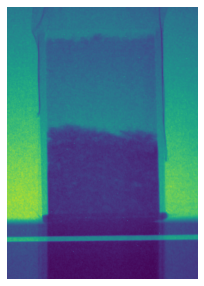

In [21]:
plt.figure(figsize=(7,5))
plt.imshow(ts2[18][::-1]) # added a flip -> originally we looked at ts2[50]
plt.axis("off");
# plt.grid()

In [22]:
intermed_ts2 = ts2[15:35,::-1, 200]

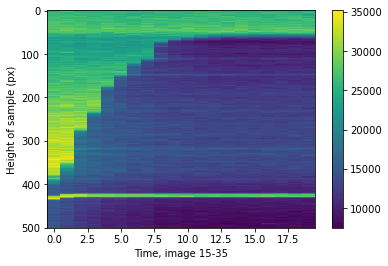

In [33]:
plt.imshow(ts2[15:35,::-1, 200].transpose(),aspect='auto', interpolation='none') # MM COMMENT -> I use 15:30 later
plt.xlabel('Time, image 15-35')
plt.ylabel('Height of sample (px)');
plt.colorbar()
# plt.savefig("sand3_time_slice.png", dpi=500)

NOTE THE TIMESLICE 15 -> 35!!! 

In [40]:
tslice= ts2[15:35,::-1,200].transpose() # 3

In [41]:
np.mean(tslice) / np.std(tslice, ddof=1)

2.461466491196543

In [42]:
# plt.imshow(tslice, aspect='auto', interpolation='none')

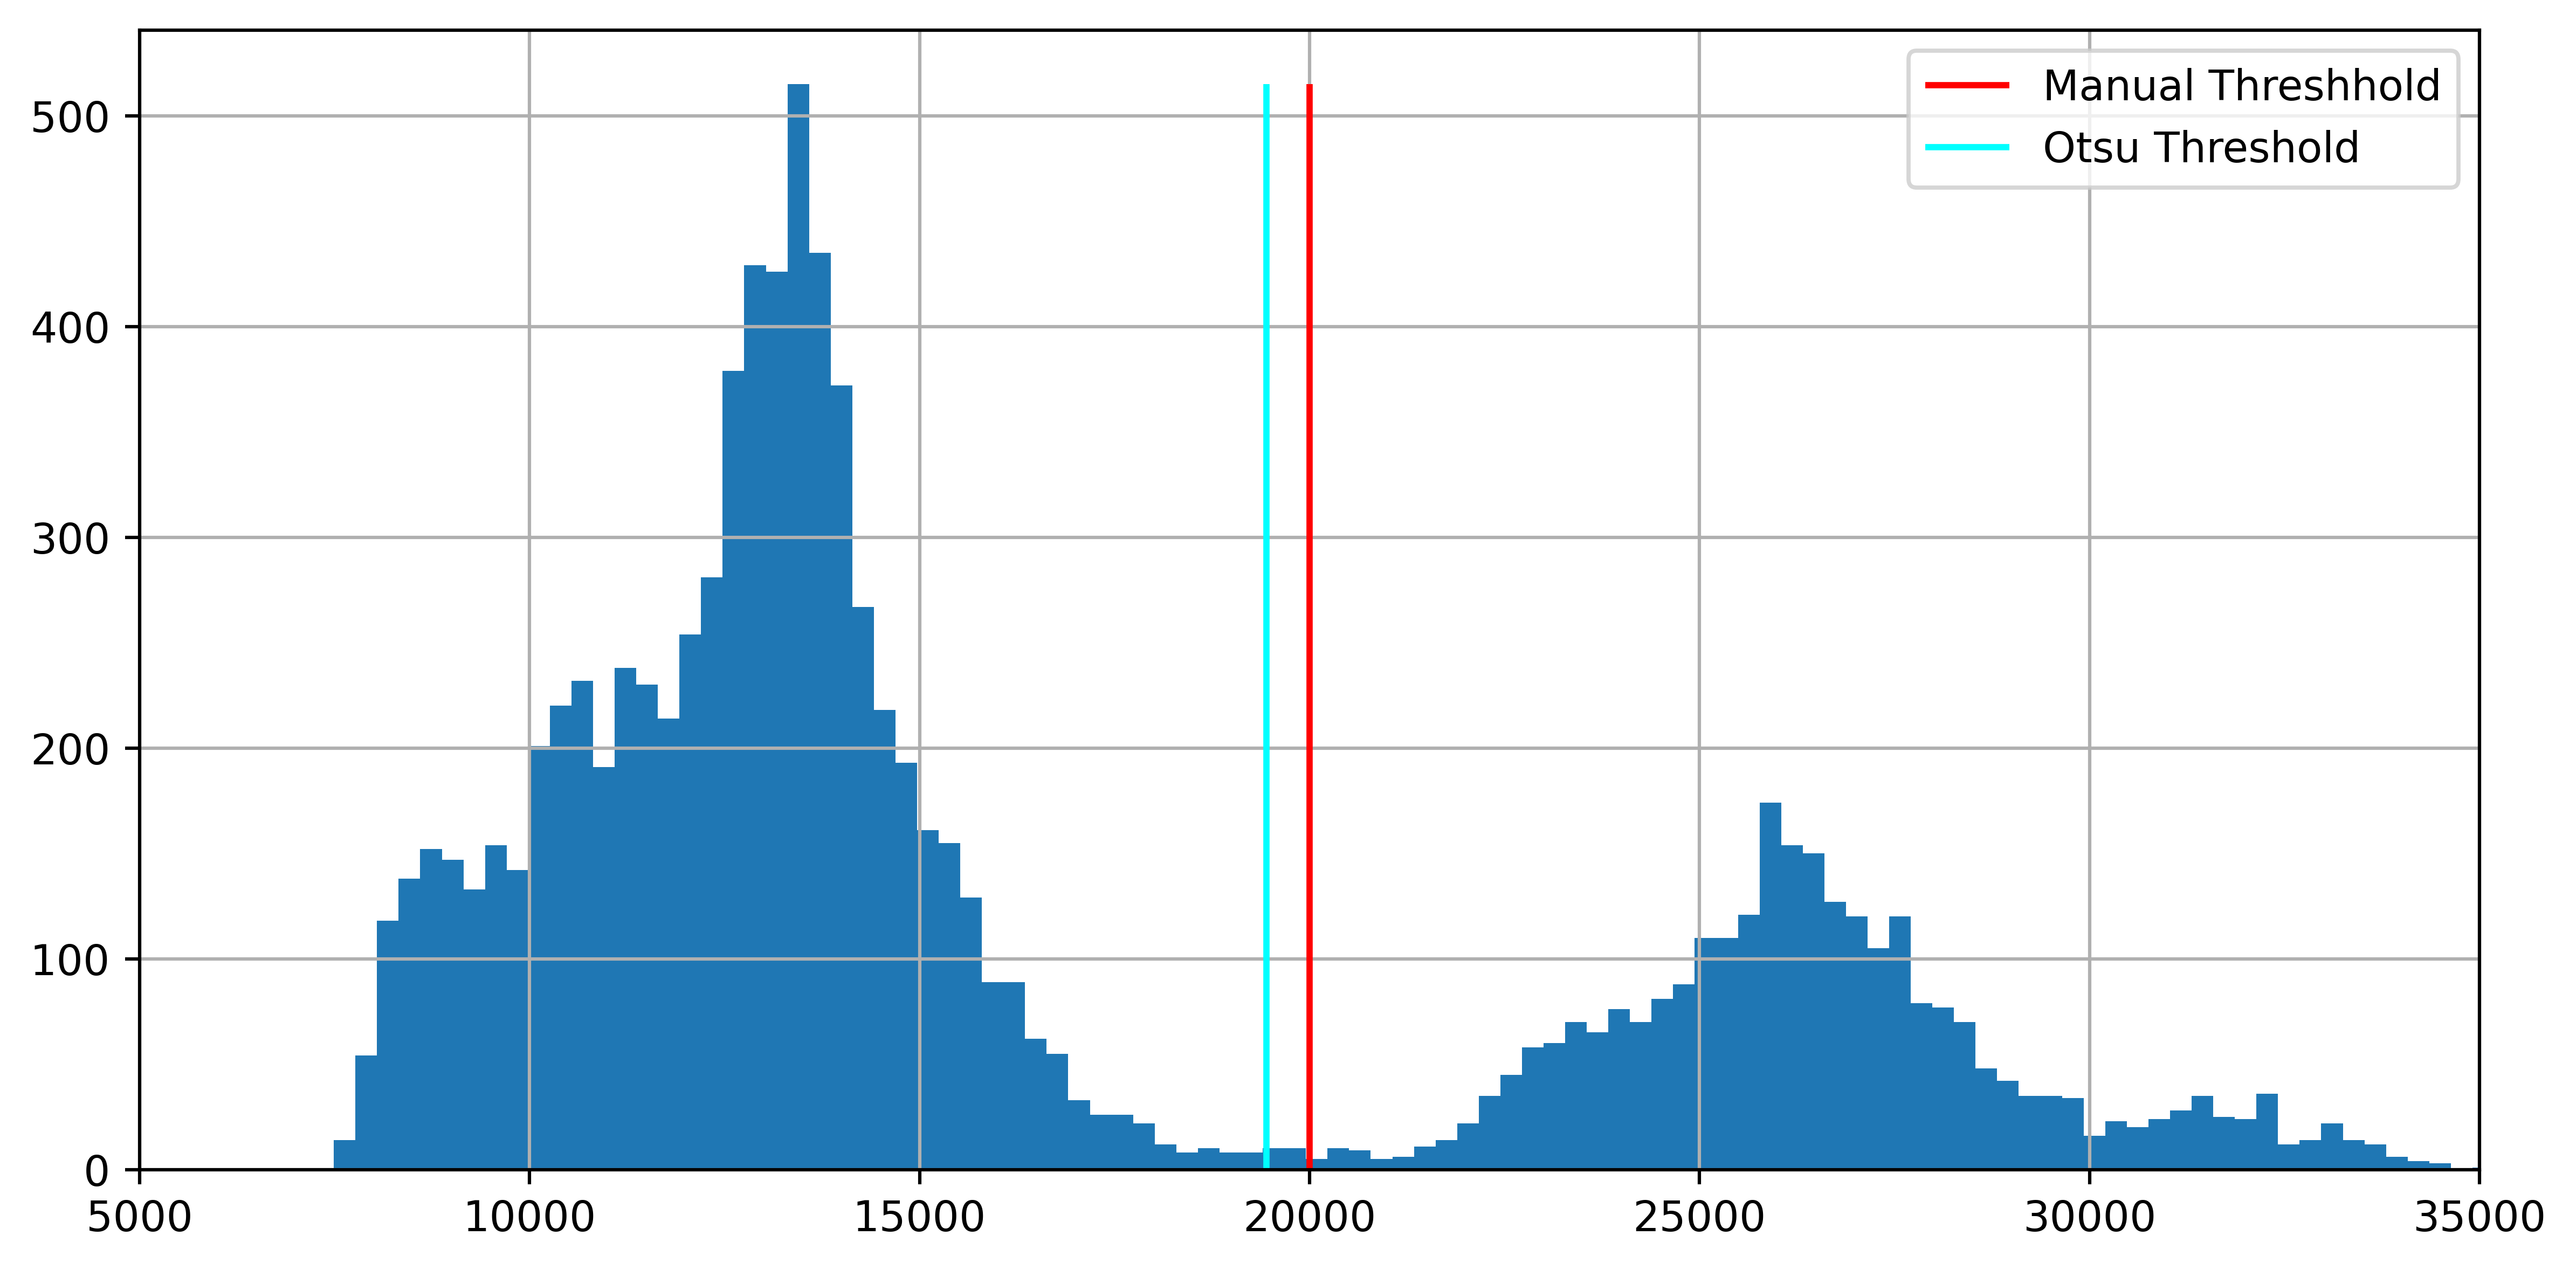

In [43]:
plt.figure(dpi=560, figsize=(10,5))
bin_fills = plt.hist(tslice.ravel(), bins=100)[0]
plt.vlines([20000],ymax=bin_fills.max(),ymin=0,color='red', label = "Manual Threshhold")
plt.vlines([threshold_otsu(tslice)],ymax=bin_fills.max(),ymin=0,color='cyan', label = "Otsu Threshold")
plt.grid()
plt.xlim(5000, 35000)
plt.legend()

Text(0.5, 0, 'Height of sample')

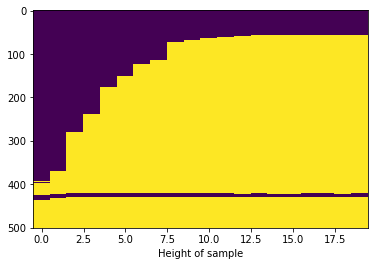

In [44]:
plt.imshow(tslice<20000,aspect='auto',interpolation='none')
plt.xlabel("Height of sample")

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10,0))
# fig.tight_layout()
a0 = ax[0].imshow(tslice, aspect='auto', interpolation='none') # MM COMMENT -> I use 15:30 later
fig.colorbar(a0, ax=ax[0])
ax[0].set_title("Time slice of capillary rise")
ax[1].imshow(tslice<20000,aspect='auto',interpolation='none')
ax[1].set_title("Identified wave front")
ax[0].set_ylabel("Penetrated height (px)")
ax[0].set_xlabel("Image 15-35")
ax[1].set_xlabel("Image 15-35")

# fig.savefig("processed_data/sand_3_capillary_rise.png", dpi=500)

Text(0.5, 0, 'Image 15-35')

ValueError: 'box_aspect' and 'fig_aspect' must be positive

<Figure size 720x0 with 3 Axes>

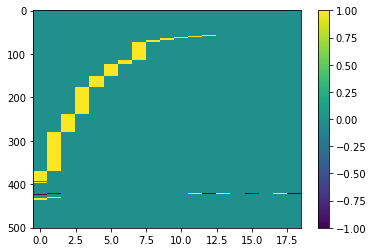

In [48]:
bts=tslice<20000
plt.imshow(bts[:,1:].astype(float)-bts[:,:-1].astype(float),aspect='auto',interpolation='none')
plt.colorbar()

In [49]:
dts=bts[:,1:].astype(float)-bts[:,:-1].astype(float)
points=np.where(0<dts)

In [15]:
# plt.imshow(dts[0])

NameError: name 'dts' is not defined

In [15]:
# help(rd)

In [16]:
# timestamps=rd.read_fits_meta_data2('data/02_rawdata/Sand/3/3_{0:05d}.fits',first=1,last=61, parlist=['FRAME'])

In [17]:
# s=timestamps['FRAME'][0][-2:]
# m=timestamps['FRAME'][0][-5:-3]
# print(m,s)

In [18]:
# m

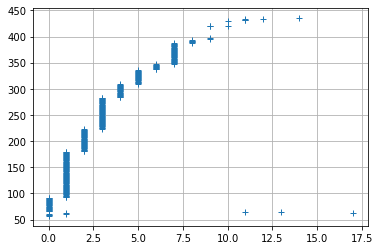

In [19]:
plt.plot(points[1], np.flip((points[0])),'+')
plt.grid()

##### From here my modifications start
Note the cutoff value below, choose such that the curve in the next few cells looks as good as possible. (few outliers)

In [20]:
cutoff = -12
# cutoff = -1

In [21]:
# (points[1], np.flip(points[0]))

In [22]:
# np.flip(points[0])

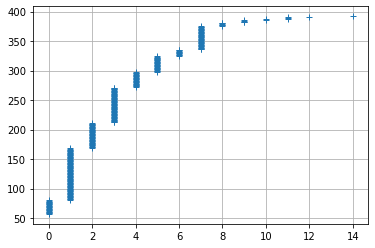

In [23]:
plt.plot(points[1][:cutoff], np.flip(points[0][:cutoff]),'+')
plt.grid()

https://neutronimaging.github.io/coding-recipes/2021/09/04/Curve-fitting.html

#### Converting into real units 

###### Time

In [24]:
import pandas as pd
import datetime 

In [25]:
timestamps_s = np.zeros((len(timestamps['FRAME']), 2))
for i in range(len(timestamps['FRAME'])):
    s=timestamps['FRAME'][i][-2:]
    m=timestamps['FRAME'][i][-5:-3]
    timestamps_s[i] = (m, s)

In [26]:
# timestamps_s

In [27]:
df = pd.DataFrame(timestamps_s)
time_array = timestamps_s[:,0] * 60 + timestamps_s[:,1]

In [28]:
time_array = pd.to_timedelta(time_array, unit='second')

watch the when the slice is made above!!!

In [29]:
# time_array[15], time_array[30], time_array[35]

In [30]:
time_array = time_array[15:31] 
# -> corresponds to times between first measuring and when the measurement is done (~30 pictures in)
# time_array

In [31]:
# np.unique(points[1][:cutoff])

In [32]:
# time_array[np.unique(points[1][:cutoff])] 

In [33]:
# time_array[np.unique(points[1][:cutoff])] - time_array[0] # normalized to time 0 being the first image

In [34]:
time_delta_array = time_array[np.unique(points[1][:cutoff])] - time_array[0]

###### Some fancy python shenanigans : switching all 14 -> 33s and so on with a dictionary trick 

In [35]:
subs = {k:v for v,k in zip(time_delta_array, np.unique(points[1][:cutoff]))}

In [36]:
new_time_array = np.array([subs.get(item,item) for item in points[1][:cutoff]])

In [37]:
new_time_array.size

336

In [38]:
@np.vectorize
def convert_timedelta_to_second_int(val):
    return val.total_seconds()

In [39]:
new_time_array = convert_timedelta_to_second_int(new_time_array)

In [40]:
# new_time_array

###### Pixel -> cm 

In [41]:
px_per_centimeter = 1578.0713/14 # px / cm
centimeter_per_pixel = px_per_centimeter**(-1)

error_factor = 1/14 # px / cm

In [42]:
cm_height = centimeter_per_pixel * np.flip(points[0][:cutoff]) * 2 # cm * px^-1 * px = cm, *2 for binning

##### Testing plot with units  

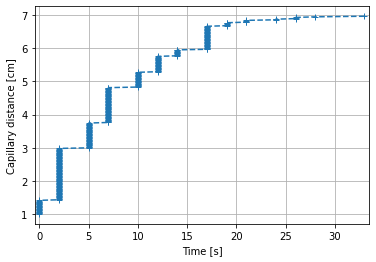

In [43]:
plt.figure()
plt.plot(new_time_array, cm_height, '+--')
plt.xlabel("Time [s]")
plt.ylabel("Capillary distance [cm]")
plt.xlim(-0.5,33.5)
plt.grid()

### Fitting 

#### Fitting -> No units 

In [287]:
from scipy.optimize import curve_fit

In [288]:
def srqt_analysis(t, a, b): # a = np.sqrt(c) c a collection of constants
    return a*np.sqrt(t)+b
# y_values = np.flip(points[0][:cutoff])
# x_values = points[1][:cutoff]
# popt, pcov = curve_fit(srqt_analysis, x_values, y_values, p0=[2.5, 0.1])

In [289]:
# a_new, b_new = popt
# new_model = lambda t: a_new * np.sqrt(t) + b_new

In [290]:
# error_factor * np.flip(points[0][:cutoff])

In [291]:
# errors = np.flip(points[0][:cutoff]) * error_factor
# plt.figure()
# plt.errorbar(points[1][:cutoff], np.flip(points[0][:cutoff]), yerr = np.ones_like(points[1][:cutoff]), marker='.')
# plt.plot(np.linspace(0,17.5,50), new_model(np.linspace(0,17.5,50)))
# plt.grid()

#### Finding means 

In [355]:
means_std = np.zeros((14, 2))
maxima = np.zeros(14)
points_new = ((points[0][:cutoff])[::-1], points[1][:cutoff])

In [356]:
for (tmp, i) in enumerate(np.unique(points_new[1])):
    indices = np.where(points_new[1] == i)
    relevant_points = points_new[0][indices]
    # means
    means_std[tmp] = (relevant_points.mean(), relevant_points.std(ddof=1))
    # maxima
    maxima[tmp] = relevant_points.max()
#     print(tmp, i, indices)

In [357]:
means_std

array([[ 68.5       ,   7.07106781],
       [124.5       ,  25.54734168],
       [190.        ,  12.5565388 ],
       [241.5       ,  17.4642492 ],
       [284.5       ,   7.64852927],
       [311.        ,   7.93725393],
       [330.        ,   3.31662479],
       [355.5       ,  11.69045194],
       [378.5       ,   1.87082869],
       [383.5       ,   1.29099445],
       [386.5       ,   0.70710678],
       [389.        ,   1.        ],
       [391.        ,          nan],
       [392.        ,          nan]])

In [358]:
# We NEVER have non-zero errors -> set it to minimum measurement accuracy (half last known digit)

In [359]:
means_std[:, 1][-2:] = np.mean(means_std[:,1][:-2]) / 2

In [360]:
means_std

array([[ 68.5       ,   7.07106781],
       [124.5       ,  25.54734168],
       [190.        ,  12.5565388 ],
       [241.5       ,  17.4642492 ],
       [284.5       ,   7.64852927],
       [311.        ,   7.93725393],
       [330.        ,   3.31662479],
       [355.5       ,  11.69045194],
       [378.5       ,   1.87082869],
       [383.5       ,   1.29099445],
       [386.5       ,   0.70710678],
       [389.        ,   1.        ],
       [391.        ,   4.08754114],
       [392.        ,   4.08754114]])

In [351]:
means_stdcm = np.array([means_std[:, 0] * centimeter_per_pixel * 2, means_std[:,1] * centimeter_per_pixel * 2]) # cm conversion

In [319]:
# means_stdcm
# means_stdcm[1][-6:-2]
# means_stdcm[1][-6:-2] *= 8
# means_stdcm[1][-2:] *= 2

In [320]:
maxima_w_error = np.array([maxima * centimeter_per_pixel * 2, maxima*centimeter_per_pixel*2/14])

In [322]:
# maxima_w_error

#### With units   - > all values

In [323]:
def sqrt_analysis(t, a, b): # a = np.sqrt(c) c a collection of constants
    return a*np.sqrt(t)+b

height = cm_height # cm
errors_height = cm_height * error_factor

time = new_time_array # s

popt, pcov = curve_fit(srqt_analysis, time, height, sigma = errors_height)

In [324]:
constants_sqrt, displacement = popt
new_model = lambda t: constants_sqrt * np.sqrt(t) + displacement   # cm = sqrt(...) * sqrt(time) -> constant has units m/time
time_linspace = np.linspace(0,35,100)

In [325]:
# plt.figure(figsize=(8,5))
# plt.errorbar(new_time_array, cm_height, yerr= errors_height, capsize=2, errorevery=5, linestyle='--', label="All values")
# # plt.errorbar(np.unique(new_time_array), means_stdcm[0], yerr=means_stdcm[1], capsize=5, marker = '.', linestyle="", label="Means of the columns")
# # plt.errorbar(np.unique(new_time_array), maxima_w_error[0], yerr=maxima_w_error[1], capsize=5, marker = '.', linestyle="", label="Maxima of the columns")
# plt.plot(time_linspace, new_model(time_linspace), label="Fit to all values")
# plt.xlabel("Time [s]")
# plt.ylabel("Capillary distance [cm]")
# plt.xlim(-0.5,35)
# plt.title("Sand 3, fitting water position")
# plt.legend(loc="lower right")
# plt.grid()


In [364]:
means_stdcm[1]

array([0.12546321, 0.45329103, 0.2227929 , 0.30987128, 0.13570922,
       0.14083211, 0.05884746, 0.20742577, 0.03319445, 0.02290634,
       0.01254632, 0.01774318, 0.14505194, 0.14505194])

##### Plotting the final image with units and the fit 

In [361]:
np.unique(new_time_array)

array([ 0.,  2.,  5.,  7., 10., 12., 14., 17., 19., 21., 24., 26., 28.,
       33.])

In [362]:
means_stdcm[0]

array([1.21540769, 2.20902566, 3.37120382, 4.28497749, 5.04793415,
       5.51812836, 5.85524875, 6.30769979, 6.71579288, 6.80450877,
       6.8577383 , 6.90209625, 6.9375826 , 6.95532578])

In [363]:
means_stdcm[1]

array([0.12546321, 0.45329103, 0.2227929 , 0.30987128, 0.13570922,
       0.14083211, 0.05884746, 0.20742577, 0.03319445, 0.02290634,
       0.01254632, 0.01774318, 0.14505194, 0.14505194])

Mean:  [0.92798791 2.32703705]
Maximum: [1.1294307  1.44101609]


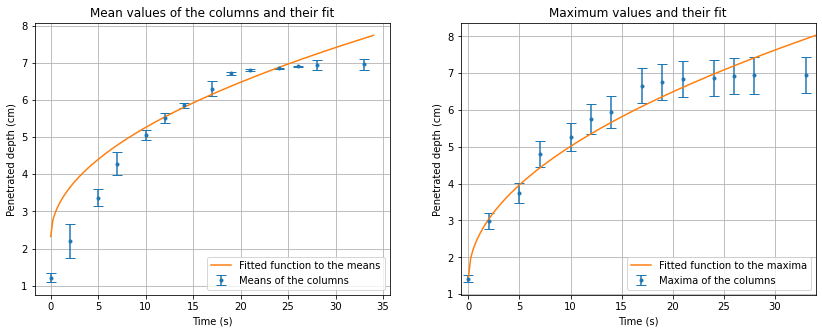

In [392]:
def sqrt_analysis(t, a, b): # a = np.sqrt(c) c a collection of constants
    return a*np.sqrt(t)+b

fig, ax = plt.subplots(1, 2, figsize=[14, 5])
ax = ax.ravel()

ax[0].set_title("Mean values of the columns and their fit")
ax[0].errorbar(np.unique(new_time_array), means_stdcm[0], yerr=means_stdcm[1], capsize=5, marker = '.', linestyle="", label="Means of the columns")

## fitting
popt, pcov = curve_fit(sqrt_analysis, np.unique(new_time_array), means_stdcm[0], sigma = means_stdcm[1]) 
print("Mean: ", popt)
new_model = lambda x: popt[0] * np.sqrt(x) + popt[1] 
new_linsp = np.linspace(0, 34, 150)

# plotting new function
ax[0].plot(new_linsp, new_model(new_linsp), label = "Fitted function to the means")
ax[0].legend(loc="lower right")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Penetrated depth (cm)")

ax[1].set_title("Maximum values and their fit")
ax[1].errorbar(np.unique(new_time_array), maxima_w_error[0], yerr=maxima_w_error[1], capsize=5, marker = '.', linestyle="", label="Maxima of the columns")

# fitting
popt, pcov = curve_fit(sqrt_analysis, np.unique(new_time_array), maxima_w_error[0], sigma = maxima_w_error[1]) 
print("Maximum:", popt)
new_model = lambda x: popt[0] * np.sqrt(x) + popt[1] 
new_linsp = np.linspace(0, 34, 150)

# plotting new function
ax[1].plot(new_linsp, new_model(new_linsp), label = "Fitted function to the maxima")
ax[1].legend(loc="lower right")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Penetrated depth (cm)")
ax[1].set_xlim(-0.75, 34)

for axis in ax:
    axis.grid()

In [390]:
means_stdcm

array([[1.21540769, 2.20902566, 3.37120382, 4.28497749, 5.04793415,
        5.51812836, 5.85524875, 6.30769979, 6.71579288, 6.80450877,
        6.8577383 , 6.90209625, 6.9375826 , 6.95532578],
       [0.12546321, 0.45329103, 0.2227929 , 0.30987128, 0.13570922,
        0.14083211, 0.05884746, 0.20742577, 0.03319445, 0.02290634,
        0.01254632, 0.01774318, 0.14505194, 0.14505194]])

In [391]:
maxima_w_error

array([[1.41945424, 2.98085391, 3.74381056, 4.80840124, 5.26972387,
        5.74878968, 5.94396464, 6.65369176, 6.76015082, 6.83112354,
        6.86660989, 6.91983943, 6.9375826 , 6.95532578],
       [0.10138959, 0.21291814, 0.26741504, 0.34345723, 0.37640885,
        0.41062783, 0.4245689 , 0.4752637 , 0.48286792, 0.4879374 ,
        0.49047214, 0.49427424, 0.49554161, 0.49680898]])

##### Calculating the pre-factor and determining the average size of the spore thingie 

In [379]:
popt[0] # cm / s^0.5

1.1294306998321235

In [382]:
# γ = 72e-3 # newtons per meter 
γ2 = 72e-3 * 1e2 # newtons per centimeter
η = 8.9e-4 # Pa * s
ϕ = 50 # degree
ϕ_rad = 50 * np.pi / 180

$L \propto \sqrt{t}$

$L = C * \sqrt{t}$

Let a be the prefactor (square root of the constants) as determined by the fit to the $\sqrt t$ data. Then it according to washburn holds:

$$ a = \sqrt{\frac{\gamma  r  cos(\phi)}{2\eta}}$$

meaning:

$$ r = \frac{2a^2 \eta}{\gamma cos(\phi)} $$

Also the unit of the prefactor as determined above is cm, but we require it in meters to determine the constants:

$$ \sqrt{\frac{N}{m} \cdot m \cdot s \cdot Pa^{-1} \cdot s^{-1}} = \sqrt{N \cdot Pa^{-1}} = \sqrt{N N^-1 \cdot m^2} = m$$

In [383]:
r = 2*η*popt[0]**2 / (γ2 * np.cos(ϕ_rad))

In [385]:
r * 1e4 #μm

4.906131516440106